# Analyze consensus motif
The third output from the computational pipeline is a fasta file of the best predicted promoter for each input sequence. For more details about how robust these predictions are, see Section 2 of `inspect_BioProspector_results.ipynb`. 

Given a fasta file of best predictions from a given set of input settings for the pipeline, we next want to 
1. Visualize the consensus motif
1. Score consensus motif PSSM matches to hexamers of predicted promoters
1. Analyze occurences of the consensus motif across the genome

For the above analyses, we moved forward with the BioProspector outputs from the top 3% of expressed genes across all conditions. However this computational framework makes it easy to produce outputs for several different top percentage threshold. We compare a range of outputs here.

4. Compare consensus motifs from different top percentage thresholds

In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import genbank_utils as gu
import consensus_viz_utils as cu

import warnings
warnings.filterwarnings('ignore')

# 1. Visualize the consensus motif

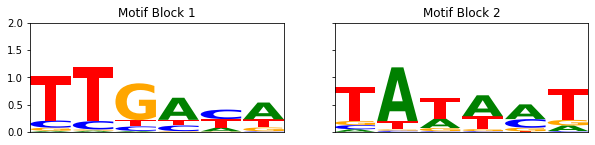

In [2]:
# Load BioPropsector output
selection_f = "n3_outdir/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952202_SELECTION.fa"
motif_blocks, m1, m2 = cu.build_2Bmotif_from_selection_file(selection_f)

# 2. Score consensus motif PSSM matches to hexamers of predicted promoters



In [3]:
hex_score_df = cu.score_predictions_to_motif(motif_blocks, m1, m2)
hex_score_df.head()

,locus_tag,desc,motif_block,hex1,hex1_score,hex2,hex2_score,total_score
0,EQU24_RS02895,EQU24_RS02895||exosortase system-associated pr...,TTGACAACATTCAACCTTTAGGCTATTGT,TTGACA,8.353386,TATTGT,5.705159,14.058544
1,EQU24_RS02970,EQU24_RS02970|pqqA|pyrroloquinoline quinone pr...,TTGCTTTGCCTAAATTATCGTCGTATACT,TTGCTT,5.215478,TATACT,7.691535,12.907013
2,EQU24_RS03495,EQU24_RS03495||cold-shock protein,TTGACTTTGGGGAAATAAGGCATAGAAT,TTGACT,7.306080,TAGAAT,5.739588,13.045668
3,EQU24_RS07185,EQU24_RS07185||glutamate--ammonia ligase,TTGTAATTGAGATCAATTAGTTGCTTATAT,TTGTAA,5.040391,TTATAT,3.933783,8.974174
4,EQU24_RS07390,EQU24_RS07390|rpmI|50S ribosomal protein L35,CTCAAGGAAACTTACTATTTTTAATCG,CTCAAG,-0.801626,TAATCG,3.369716,2.568090


In [4]:
# scatter plot of hex1 vs hex 2
scatter = alt.Chart(
    hex_score_df,
).mark_point().encode(
    x=alt.X('hex1_score:Q',axis=alt.Axis(title="-35 Consensus Match")),
    y=alt.Y('hex2_score:Q',axis=alt.Axis(title="-10 Consensus Match")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
).properties(
    width=200,
    height=200
).interactive()

# stripplot showing total score (hex1 + hex2)
stripplot = alt.Chart(
    hex_score_df,
).mark_point().encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    y=alt.Y(
        'total_score:Q',
        axis=alt.Axis(title="Total Consensus Score")),
    color=alt.Color(
        'total_score:Q',
        scale=alt.Scale(scheme='viridis'),
        sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).properties(height=200, width=50
).interactive()

# horizontally concat plots
combo = alt.hconcat(
    scatter, 
    stripplot,
    title=f"Consensus motif match scores to promoter predictions"
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    anchor='middle',
    fontSize=20
)

In [5]:
combo

alt.HConcatChart(...)

# 3. Analyze occurences of the consensus motif across the genome
## Load genome and feature coords from genbank

In [6]:
gbFile_5G = 'data/5GB1c_sequence.gb'

GENOME_FWD, GENOME_REV,GENOME_LEN = gu.get_genome_fwd_rev_len(gbFile_5G)
print("Genome length:", GENOME_LEN, "bps")
print(GENOME_FWD[:10])
print(GENOME_REV[-10:])

# put into a tuple for a later function that expects this format
genomes = [
    ('genome_fwd','genome_fwd',GENOME_FWD),
    ('genome_rev','genome_rev',GENOME_REV)
]

Genome length: 4998879 bps
ATGAGTGCAC
GTGCACTCAT


In [7]:
pos_feat_coords, neg_feat_coords = gu.get_pos_neg_relative_feature_coords(gbFile_5G, GENOME_LEN)

### Build distance arrays of the nearest feature to every position in the genome

In [8]:
pos_dist_array,pos_nearest_feat_array = cu.build_feature_distance_index(pos_feat_coords,GENOME_LEN)
neg_dist_array,neg_nearest_feat_array = cu.build_feature_distance_index(neg_feat_coords,GENOME_LEN)

# make category df for all positions in the gneome to get baseline counts
# of each category
baseline_cat_df = cu.build_genome_position_category_df(pos_dist_array, neg_dist_array)
baseline_cat_df.head()

,cat,pos_count,neg_count,total
0,in gene,2017571,2133177,4150748
1,100:300 to ATG,206887,208575,415462
2,<100 to ATG,140842,144902,285744
3,intergenic,2633579,2512225,5145804
4,<300 to ATG,347729,353477,701206


### Search for the consensus across the genome

In [9]:
# from the consensus motif blocks, build variably spaced PSSMs (with 15-18bp spacers)
var_spaced_motifs = cu.build_dict_of_motifs_to_try(m1, m2)

# search for PSSM matches in the forward and reverse direction
motif_match_df = cu.find_and_score_motifs_in_seqs(var_spaced_motifs,genomes,{})
motif_match_df.head()

,seq_id,seq_name,score,pos,seq_len,spacer,full_seq,match_best?
0,genome_fwd,genome_fwd,0.009014,8,4998879,15,ACTCTGGAACAACTGTCTCGCTAAACT,False
1,genome_fwd,genome_fwd,4.560510,20,4998879,15,CTGTCTCGCTAAACTTGAAAATGAAAT,False
2,genome_fwd,genome_fwd,4.211860,34,4998879,15,TTGAAAATGAAATTTCTTCCTCGGAAT,False
3,genome_fwd,genome_fwd,0.515077,50,4998879,15,TTCCTCGGAATTCAGCACCTGGATTAG,False
4,genome_fwd,genome_fwd,2.806593,91,4998879,15,TCGAAACCGATGGACAAATCAAGTTAT,False


### Analyze the number of matches in each genome category

In [10]:
motif_match_cat_df = cu.analyze_motif_matches_across_genome(
    motif_match_df,
    baseline_cat_df,
    pos_dist_array,
    pos_nearest_feat_array,
    neg_dist_array,
    neg_nearest_feat_array)

motif_match_cat_df

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts


,cat,pos_count,neg_count,total,pssm_match_count,match_perc
0,in gene,2017571,2133177,4150748,481616,0.116031
1,100:300 to ATG,206887,208575,415462,69177,0.166506
2,<100 to ATG,140842,144902,285744,62479,0.218654
3,intergenic,2633579,2512225,5145804,692056,0.134489
4,<300 to ATG,347729,353477,701206,131656,0.187757


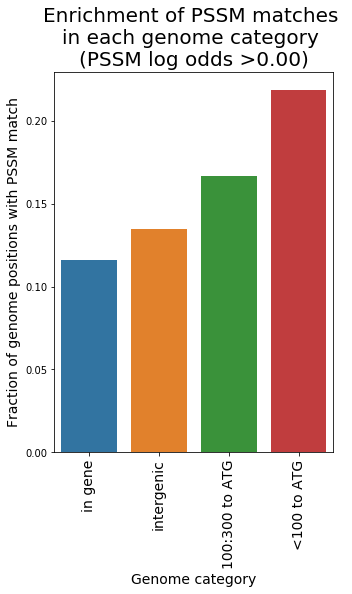

In [11]:
cu.genome_category_normed_bar(motif_match_cat_df)

### Analyze the number of high scoring matches in each genome category

In [12]:
# get the average score threshold needed to be above a given False Positive Rate 
# for each of the variably spaced motifs
print("Calculating PSSM score threshold")
fpr = 0.0001
threshold = np.mean([var_spaced_motifs[x].distribution().threshold_fpr(fpr) for x in var_spaced_motifs])
top_motif_match_df = motif_match_df[motif_match_df['score']>threshold]

top_motif_match_cat_df = cu.analyze_motif_matches_across_genome(
    top_motif_match_df,
    baseline_cat_df,
    pos_dist_array,
    pos_nearest_feat_array,
    neg_dist_array,
    neg_nearest_feat_array)

top_motif_match_cat_df

Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts


,cat,pos_count,neg_count,total,pssm_match_count,match_perc
0,in gene,2017571,2133177,4150748,1860,0.000448
1,100:300 to ATG,206887,208575,415462,440,0.001059
2,<100 to ATG,140842,144902,285744,521,0.001823
3,intergenic,2633579,2512225,5145804,3115,0.000605
4,<300 to ATG,347729,353477,701206,961,0.001370


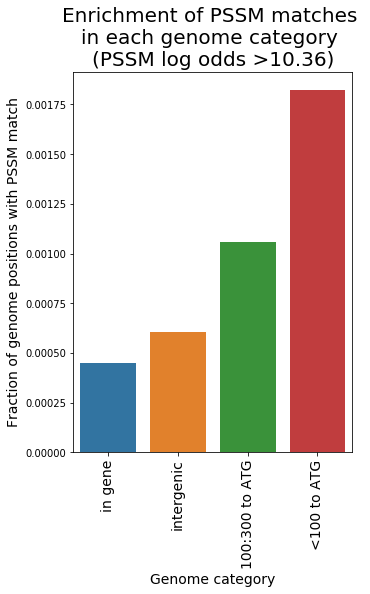

In [13]:
cu.genome_category_normed_bar(top_motif_match_cat_df,threshold=threshold)

# 4. Compare consensus motifs from different top percentage thresholds
While the above analyses use the top 3% of expressed genes, it may be useful to compare results for different percentage thresholds. Here we examine the top 1,2,3,4,5,6,10,and 20% thresholds.

In [14]:
# dictionary of various biopropsector pipeline outputs
f_dict = {
    1:'n1_outdir/loci_in_top_1perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952145_SELECTION.fa',
    2:'n2_outdir/loci_in_top_2perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599038857_SELECTION.fa',
    3:'n3_outdir/loci_in_top_3perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952202_SELECTION.fa',
    4:'n4_outdir/loci_in_top_4perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599039044_SELECTION.fa',
    5:'n5_outdir/loci_in_top_5perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952321_SELECTION.fa',
    6:'n6_outdir/loci_in_top_6perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1599039246_SELECTION.fa',
    10:'n10_outdir/loci_in_top_10perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598952515_SELECTION.fa',
    20:'n20_outdir/loci_in_top_20perc_upstream_regions_w300_min20_trunc_W6_w6_G18_g15_d1_a1_n200_1598953063_SELECTION.fa'
}

In [36]:
def compare_consensus_motifs(f_dict):
    hex_score_dfs = {}
    motif_match_cat_dfs = {}
    top_motif_match_cat_dfs = {}
    # loop through all selection files
    for nperc in f_dict:
        print(f"Top {nperc}% consensus")
        # extract the consensus motif in 2 blocks
        motif_blocks, m1, m2 = cu.build_2Bmotif_from_selection_file(f_dict[nperc])
        
        hex_score_df = cu.score_predictions_to_motif(motif_blocks, m1, m2)
        hex_score_dfs[nperc] = hex_score_df

        # while we have a specific consensus motif block for this file, search
        # for it across the genome
        # from the consensus motif blocks, build variably spaced PSSMs (with 15-18bp spacers)
        var_spaced_motifs = cu.build_dict_of_motifs_to_try(m1, m2)

        # search for PSSM matches in the forward and reverse direction
        motif_match_df = cu.find_and_score_motifs_in_seqs(var_spaced_motifs,genomes,{})
        
        motif_match_cat_df = cu.analyze_motif_matches_across_genome(
            motif_match_df,
            baseline_cat_df,
            pos_dist_array,
            pos_nearest_feat_array,
            neg_dist_array,
            neg_nearest_feat_array)
        
        
        # also calculate enrichment for the top scoring matches
        print("Calculating PSSM score threshold")
        fpr = 0.0001
        threshold = np.mean([var_spaced_motifs[x].distribution().threshold_fpr(fpr) for x in var_spaced_motifs])
        top_motif_match_df = motif_match_df[motif_match_df['score']>threshold]

        top_motif_match_cat_df = cu.analyze_motif_matches_across_genome(
            top_motif_match_df,
            baseline_cat_df,
            pos_dist_array,
            pos_nearest_feat_array,
            neg_dist_array,
            neg_nearest_feat_array)
        
        
        
        motif_match_cat_dfs[nperc] = motif_match_cat_df
        top_motif_match_cat_dfs[nperc] = top_motif_match_cat_df
    
    return hex_score_dfs, motif_match_cat_dfs, top_motif_match_cat_dfs

Top 1% consensus


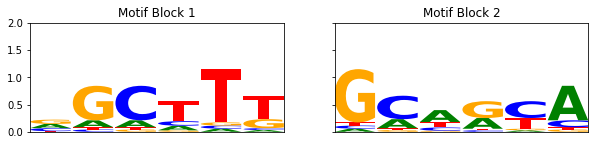

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 2% consensus


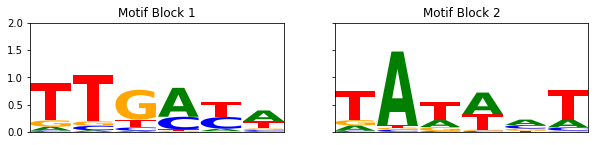

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 3% consensus


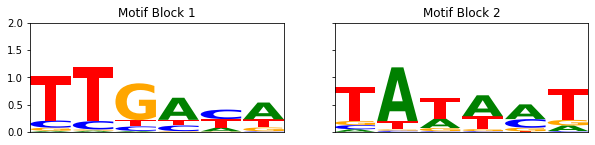

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 4% consensus


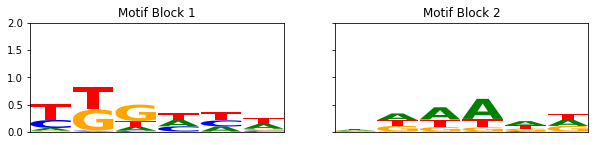

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 5% consensus


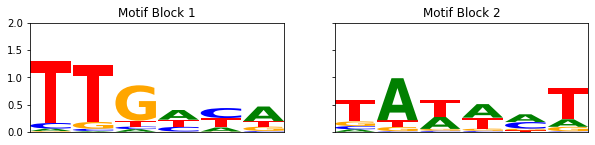

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 6% consensus


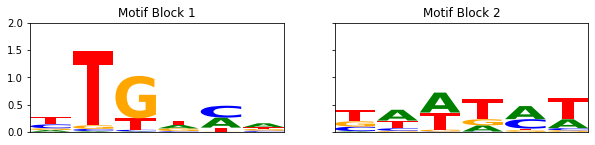

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 10% consensus


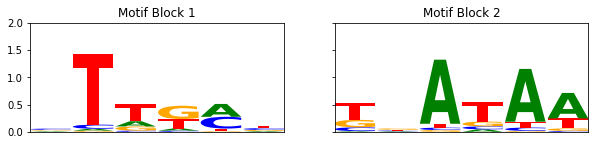

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Top 20% consensus


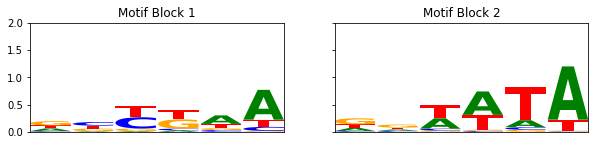

Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts
Calculating PSSM score threshold
Adding categories to pssm matches...
done motifs...
done near feats...
Normalizing pssm match counts


In [37]:
hex_score_dfs, motif_match_cat_dfs, top_motif_match_cat_dfs = compare_consensus_motifs(f_dict)

In [38]:
hex_score_dfs[1]

,locus_tag,desc,motif_block,hex1,hex1_score,hex2,hex2_score,total_score
0,EQU24_RS12095,EQU24_RS12095||cytochrome c,CGCTTTATCTCAAAATCCTAGCGAAACA,CGCTTT,7.692483,GAAACA,6.110931,13.803413
1,EQU24_RS12525,EQU24_RS12525|ssrA|transfer-messenger RNA,GAATTTAATTGTTAATATCGCGCAACA,GAATTT,3.534054,GCAACA,7.489443,11.023497
2,EQU24_RS16195,EQU24_RS16195||hypothetical protein,AGCATTACCCTAAAATGACCGCGCGAAGTA,AGCATT,6.062433,GAAGTA,6.110931,12.173364
3,EQU24_RS18140,EQU24_RS18140|moxF|PQQ-dependent dehydrogenase...,CGCTTTTCCCGTCATCTGGGTGCTGTA,CGCTTT,7.692483,GCTGTA,6.351939,14.044422
4,EQU24_RS18355,EQU24_RS18355||hypothetical protein,GGCTTGACGGCGGCTATCCCTGCCGCC,GGCTTG,6.799398,GCCGCC,3.945122,10.744520
5,EQU24_RS19315,EQU24_RS19315|pmoC|methane monooxygenase/ammon...,AGCCTTTTCGAAATGATAAACTGAGCAGCA,AGCCTT,6.062433,GCAGCA,8.141520,14.203953
6,EQU24_RS19765,EQU24_RS19765|rnpB|RNase P RNA component class A,GGCTTGACAAATGGATTAAATGTCGCAATA,GGCTTG,6.799398,GCAATA,6.837366,13.636765
7,EQU24_RS22110,EQU24_RS22110||hypothetical protein,AGCTTTAATTTGATGGAATTTCTGCTGCA,AGCTTT,8.177910,GCTGCA,7.004016,15.181926


In [39]:
all_hex_dfs = []
for nperc in hex_score_dfs:
    df = hex_score_dfs[nperc]
    df['nperc'] = nperc
    all_hex_dfs.append(df)
all_hex_df = pd.concat(all_hex_dfs)
all_hex_df.to_csv('all_hex_df.tsv',sep='\t',index=False)
all_hex_df

,locus_tag,desc,motif_block,hex1,hex1_score,hex2,hex2_score,total_score,nperc
0,EQU24_RS12095,EQU24_RS12095||cytochrome c,CGCTTTATCTCAAAATCCTAGCGAAACA,CGCTTT,7.692483,GAAACA,6.110931,13.803413,1
1,EQU24_RS12525,EQU24_RS12525|ssrA|transfer-messenger RNA,GAATTTAATTGTTAATATCGCGCAACA,GAATTT,3.534054,GCAACA,7.489443,11.023497,1
2,EQU24_RS16195,EQU24_RS16195||hypothetical protein,AGCATTACCCTAAAATGACCGCGCGAAGTA,AGCATT,6.062433,GAAGTA,6.110931,12.173364,1
3,EQU24_RS18140,EQU24_RS18140|moxF|PQQ-dependent dehydrogenase...,CGCTTTTCCCGTCATCTGGGTGCTGTA,CGCTTT,7.692483,GCTGTA,6.351939,14.044422,1
4,EQU24_RS18355,EQU24_RS18355||hypothetical protein,GGCTTGACGGCGGCTATCCCTGCCGCC,GGCTTG,6.799398,GCCGCC,3.945122,10.744520,1
...,...,...,...,...,...,...,...,...,...
206,EQU24_RS21920,EQU24_RS21920||peptidase M4,GTATAAAGTGAGTAGAACTCGTCCATATA,GTATAA,1.277953,CATATA,2.946846,4.224798,20
207,EQU24_RS21930,EQU24_RS21930||ribulose-phosphate 3-epimerase,TTGCTTGTTTTGTTTTAATCGAGGATA,TTGCTT,-3.078133,AGGATA,2.595738,-0.482394,20
208,EQU24_RS22050,EQU24_RS22050||winged helix-turn-helix transcr...,GCCGAAATTTCAAGTGCAAAAGGTATA,GCCGAA,5.385527,GGTATA,7.076483,12.462010,20
209,EQU24_RS22110,EQU24_RS22110||hypothetical protein,GCTTTAATTTGATGGAATTTCTGCTGCATT,GCTTTA,4.455119,TGCATT,1.288597,5.743716,20


In [40]:
stripplot = alt.Chart(
    all_hex_df,
    #title=f"Prediction consensus matches"
).mark_point().encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    y=alt.Y('total_score:Q',axis=alt.Axis(title="Total Consensus Score")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
    column=alt.Column(
        'nperc:N', 
        header=alt.Header(
            labelFontSize=16,
            labelAngle=0,
            titleOrient='top',
            labelOrient='bottom',
            labelAlign='center',
            labelPadding=25,
       ),
    ),
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=16,
    titleFontSize=16
).properties(height=200, width=100)

stripplot

alt.Chart(...)

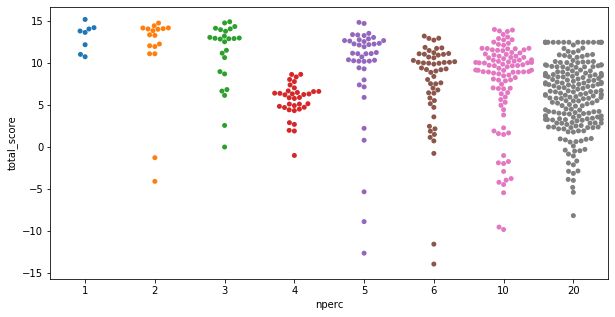

In [41]:
fig = plt.figure(figsize=(10,5))
sns.swarmplot(data=all_hex_df, x='nperc',y='total_score')

In [42]:
motif_match_cat_dfs[1]

,cat,pos_count,neg_count,total,pssm_match_count,match_perc
0,in gene,2017571,2133177,4150748,674514,0.162504
1,100:300 to ATG,206887,208575,415462,65080,0.156645
2,<100 to ATG,140842,144902,285744,44618,0.156147
3,intergenic,2633579,2512225,5145804,811543,0.157710
4,<300 to ATG,347729,353477,701206,109698,0.156442


In [43]:
all_cat_dfs = []
for nperc in motif_match_cat_dfs:
    df = motif_match_cat_dfs[nperc]
    df['nperc'] = nperc
    all_cat_dfs.append(df)
all_cat_df = pd.concat(all_cat_dfs)
all_cat_df.to_csv('all_cat_df.tsv',sep='\t',index=False)
all_cat_df

,cat,pos_count,neg_count,total,pssm_match_count,match_perc,nperc
0,in gene,2017571,2133177,4150748,674514,0.162504,1
1,100:300 to ATG,206887,208575,415462,65080,0.156645,1
2,<100 to ATG,140842,144902,285744,44618,0.156147,1
3,intergenic,2633579,2512225,5145804,811543,0.157710,1
4,<300 to ATG,347729,353477,701206,109698,0.156442,1
0,in gene,2017571,2133177,4150748,520998,0.125519,2
1,100:300 to ATG,206887,208575,415462,73414,0.176704,2
2,<100 to ATG,140842,144902,285744,66971,0.234374,2
3,intergenic,2633579,2512225,5145804,726035,0.141093,2
4,<300 to ATG,347729,353477,701206,140385,0.200205,2


In [44]:
top_all_cat_dfs = []
for nperc in top_motif_match_cat_dfs:
    df = top_motif_match_cat_dfs[nperc]
    df['nperc'] = nperc
    top_all_cat_dfs.append(df)
top_all_cat_df = pd.concat(top_all_cat_dfs)
top_all_cat_df.to_csv('top_all_cat_df.tsv',sep='\t',index=False)
top_all_cat_df

,cat,pos_count,neg_count,total,pssm_match_count,match_perc,nperc
0,in gene,2017571,2133177,4150748,2801,0.000675,1
1,100:300 to ATG,206887,208575,415462,233,0.000561,1
2,<100 to ATG,140842,144902,285744,167,0.000584,1
3,intergenic,2633579,2512225,5145804,3478,0.000676,1
4,<300 to ATG,347729,353477,701206,400,0.000570,1
0,in gene,2017571,2133177,4150748,1774,0.000427,2
1,100:300 to ATG,206887,208575,415462,418,0.001006,2
2,<100 to ATG,140842,144902,285744,536,0.001876,2
3,intergenic,2633579,2512225,5145804,2996,0.000582,2
4,<300 to ATG,347729,353477,701206,954,0.001361,2


In [45]:
def compare_genome_cat_enrichment(df):
    fig, axes = plt.subplots(nrows=2, ncols=8, sharey=True, figsize=(15,8))
    axes_list = [item for sublist in axes for item in sublist] 
    genome_cat_order = ['in gene','intergenic','100:300 to ATG','<100 to ATG']

    for nperc, sub_df in df.groupby("nperc"):
        # calculate the rank of each match by vote count

        # make the bar chart on the next axis
        ax = axes_list.pop(0)
        sns.barplot(data=sub_df,x='cat',y='match_perc',ax=ax,order=genome_cat_order)



    #     # axis and title configs
        ax.set_title(f"{nperc} %")#.split('|')[0])
        #ax.set_xticks(angle=90) 
        ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
        ax.set_xlabel("")
    #     ax.set_ylabel("BioP votes")

    # Now use the matplotlib .remove() method to 
    # delete anything we didn't use
    for ax in axes_list:
        ax.remove()

    return fig.tight_layout()

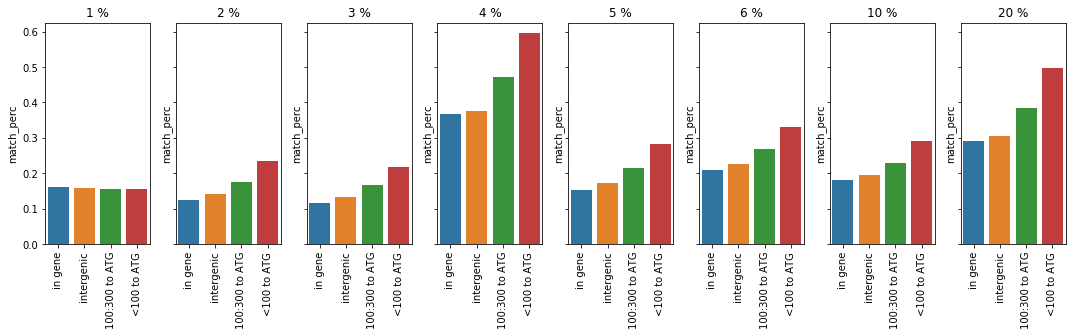

In [46]:
compare_genome_cat_enrichment(all_cat_df)

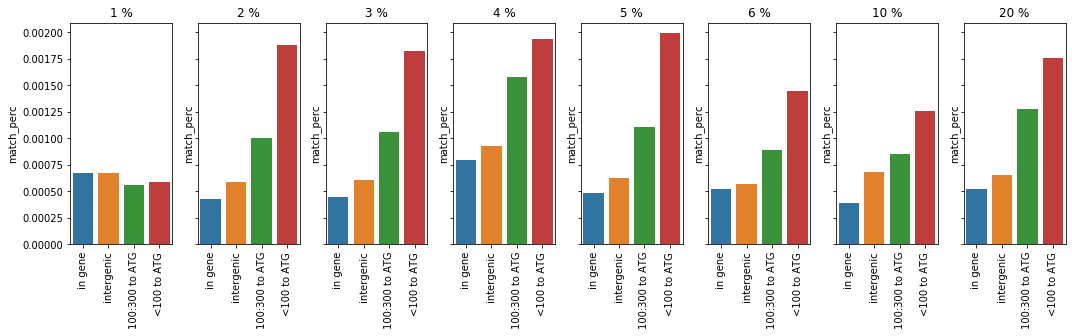

In [47]:
compare_genome_cat_enrichment(top_all_cat_df)

In [10]:
import dask.dataframe as dd
from dask.multiprocessing import get

In [11]:
# go through all the pssm matches found and determine they're intergenic category
def get_intergenic_category(row,dist_array):
    '''
    Given a pssm match row and a dist array, return the type of 
    intergenic category it is based on distance to the feature
    '''
    # get the ending position of the motif (2 hexamers + spacer -1 for indexing)
    pssm_start_pos = row['pos']
    pssm_end_pos = pssm_start_pos + 12 + row['spacer'] - 1
    
    pos_dist = int(dist_array[pssm_end_pos])
    
    if pos_dist == -1:
        cat = "in gene"
    elif pos_dist <= 100:
        cat = "<100 to ATG"
    elif pos_dist <=300:
        cat = "100:300 to ATG"
    else:
        cat = "intergenic"
        
    return cat

def add_intergenic_category_column(row, 
                                   pos_dist_array, 
                                   neg_dist_array):
    '''
    Given a pssm match row, get it's intergenic category. Take into account fwd vs rev
    '''
    genome_version = row['seq_id']
    
    if genome_version == 'genome_fwd':
        return get_intergenic_category(row,pos_dist_array)
    elif genome_version == 'genome_rev':
        return get_intergenic_category(row,neg_dist_array)
    else: 
        raise ValueError(f"Unknown genome direction {genome_version}. This function is for whole genome motif searches (genome_fwd or genome_rev)")



In [13]:

ddata = dd.from_pandas(motif_match_df, npartitions=30)


In [15]:
ddata.head()

,seq_id,seq_name,score,pos,seq_len,spacer,full_seq,match_best?
0,genome_fwd,genome_fwd,0.009014,8,4998879,15,ACTCTGGAACAACTGTCTCGCTAAACT,False
1,genome_fwd,genome_fwd,4.560510,20,4998879,15,CTGTCTCGCTAAACTTGAAAATGAAAT,False
2,genome_fwd,genome_fwd,4.211860,34,4998879,15,TTGAAAATGAAATTTCTTCCTCGGAAT,False
3,genome_fwd,genome_fwd,0.515077,50,4998879,15,TTCCTCGGAATTCAGCACCTGGATTAG,False
4,genome_fwd,genome_fwd,2.806593,91,4998879,15,TCGAAACCGATGGACAAATCAAGTTAT,False


ValueError: Expected iterable of tuples of (name, dtype), got [array(['-1', '-1', '-1', ..., '3', '2', '1'], dtype='<U15'), array(['170', '169', '168', ..., '173', '172', '171'], dtype='<U15')]

In [12]:
motif_match_df['motif_loc'] = motif_match_df.apply(lambda row: add_intergenic_category_column(row, pos_dist_array, neg_dist_array),axis=1)

In [11]:
motif_match_df.head()

,seq_id,seq_name,score,pos,seq_len,spacer,full_seq,match_best?,motif_loc,nearest_feat
0,genome_fwd,genome_fwd,0.009014,8,4998879,15,ACTCTGGAACAACTGTCTCGCTAAACT,False,in gene,EQU24_RS00005
1,genome_fwd,genome_fwd,4.560510,20,4998879,15,CTGTCTCGCTAAACTTGAAAATGAAAT,False,in gene,EQU24_RS00005
2,genome_fwd,genome_fwd,4.211860,34,4998879,15,TTGAAAATGAAATTTCTTCCTCGGAAT,False,in gene,EQU24_RS00005
3,genome_fwd,genome_fwd,0.515077,50,4998879,15,TTCCTCGGAATTCAGCACCTGGATTAG,False,in gene,EQU24_RS00005
4,genome_fwd,genome_fwd,2.806593,91,4998879,15,TCGAAACCGATGGACAAATCAAGTTAT,False,in gene,EQU24_RS00005


In [14]:
motif_match_df['motif_loc2'] = motif_match_df.parallel_apply(lambda row: add_intergenic_category_column(row, pos_dist_array, neg_dist_array),axis=1)
motif_match_df.head()

,seq_id,seq_name,score,pos,seq_len,spacer,full_seq,match_best?,motif_loc,motif_loc2
0,genome_fwd,genome_fwd,0.009014,8,4998879,15,ACTCTGGAACAACTGTCTCGCTAAACT,False,in gene,in gene
1,genome_fwd,genome_fwd,4.560510,20,4998879,15,CTGTCTCGCTAAACTTGAAAATGAAAT,False,in gene,in gene
2,genome_fwd,genome_fwd,4.211860,34,4998879,15,TTGAAAATGAAATTTCTTCCTCGGAAT,False,in gene,in gene
3,genome_fwd,genome_fwd,0.515077,50,4998879,15,TTCCTCGGAATTCAGCACCTGGATTAG,False,in gene,in gene
4,genome_fwd,genome_fwd,2.806593,91,4998879,15,TCGAAACCGATGGACAAATCAAGTTAT,False,in gene,in gene


In [18]:
sum(motif_match_df['motif_loc'].values != motif_match_df['motif_loc2'].values)

0

In [ ]:
stripplot = alt.Chart(
    hex_score_df,
    #title=f"Prediction consensus matches"
).mark_point().encode(
    x=alt.X(
        'jitter:Q',
        title=None,
        axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
        scale=alt.Scale()
    ),
    y=alt.Y('total_score:Q',axis=alt.Axis(title="Total Consensus Score")),
    color=alt.Color('total_score:Q',scale=alt.Scale(scheme='viridis'),sort='descending'),
    size=alt.value(100),
    tooltip=["desc:N","hex1:N",'hex2:N','total_score:Q'],
#     column=alt.Column(
#         'nperc:N', 
# #         header=alt.Header(
# #             labelFontSize=16,
# #             labelAngle=0,
# #             titleOrient='top',
# #             labelOrient='bottom',
# #             labelAlign='center',
# #             labelPadding=25,
# #        ),
#     ),
).transform_calculate(
    # Generate Gaussian jitter with a Box-Muller transform
    jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
# ).configure_facet(
#     spacing=0
# ).configure_view(
#     stroke=None
# ).configure_axis(
#     labelFontSize=16,
#     titleFontSize=16
).properties(height=200, width=100)

combo = alt.hconcat(
    scatter, 
    stripplot,
    title=f"Prediction consensus matches"
).configure_facet(
    spacing=0
).configure_view(
    stroke=None
).configure_axis(
    labelFontSize=16,
    titleFontSize=16,
).configure_title(
    #align='center',
    anchor='middle',
    fontSize=20
)